In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

### Functions Used

In [11]:
def calculate_filter_size(sigma, T):
    sHalf = round(math.sqrt(-math.log(T) * 2 * sigma**2))
    N= 2*sHalf +1
    return N

def gradient_x(x,y,sigma):
    x1=np.exp(-(x**2+y**2)/(2*sigma**2))
    c=-2*(x)/(2*sigma**2) 
    fx= c*x1
    return fx 

def gradient_y(x,y,sigma):
    y1=np.exp(-(x**2+y**2)/(2*sigma**2))
    c=-2*(y)/(2*sigma**2) 
    fy=c*y1
    return fy

def calculate_gradient (filter_size, sigma):
    fx=np.ndarray((filter_size,filter_size))
    fy=np.ndarray((filter_size,filter_size))
    for x in range (filter_size):
        for y in range (filter_size):
            fx[x,y]=gradient_x(x-int(filter_size/2),y-int(filter_size/2),sigma)
            fy[x,y]=gradient_y(x-int(filter_size/2),y-int(filter_size/2),sigma)
    return fx, fy

def Mask_generater(sigma,T):
    filter_size=calculate_filter_size(sigma, T)
    fx,fy=calculate_gradient(filter_size, sigma)
    return fx, fy

def scale_up(x, scale):
    return np.around(x*scale).astype('int')


def scale_down(x, scale):
    return np.around(x/scale).astype('int')


def convolution(image, kernel, stride):
    image_h, image_w=image.shape
    kernel_h, kernel_w=kernel.shape
    Out_image_h=(image_h-kernel_h)//stride +1
    Out_image_w=(image_w-kernel_w)//stride +1
    output=np.ndarray((Out_image_h,Out_image_w)) #empty output array
    kernel=np.flipud(kernel)
    kernel=np.fliplr(kernel)
    
    for x in range(Out_image_h-kernel_h+1):
        for y in range (Out_image_w-kernel_w+1):
            image_sliced = image[...,x:x+kernel_h, y:y+kernel_w]
            product = np.multiply(image_sliced,kernel)
            output[x][y]=product.sum()
    return output

def NonMaxSup(magnitude, gradient_direction):
    NonMaxSup_value = np.zeros(magnitude.shape)
    for x in range(1, int(magnitude.shape[0]) - 1):
        for y in range(1, int(magnitude.shape[1]) - 1):
            if((gradient_direction[x,y] >= 0 and gradient_direction[x,y] <= 22.5) or (gradient_direction[x,y] >= 157.5 and gradient_direction[x,y] <= 202.5) or (gradient_direction[x,y] >= 337.5 and gradient_direction[x,y] <= 360)):
                if((magnitude[x,y] > magnitude[x,y+1]) and (magnitude[x,y] > magnitude[x,y-1])):
                    NonMaxSup_value[x,y] = magnitude[x,y]
                else:
                    NonMaxSup_value[x,y] = 0
            if((gradient_direction[x,y] >= 22.5 and gradient_direction[x,y] <= 67.5) or (gradient_direction[x,y] >= 202.5 and gradient_direction[x,y] <= 247.5)):
                if((magnitude[x,y] > magnitude[x+1,y+1]) and (magnitude[x,y] > magnitude[x-1,y-1])):
                    NonMaxSup_value[x,y] = magnitude[x,y]
                else:
                    NonMaxSup_value[x,y] = 0
            if((gradient_direction[x,y] >= 67.5 and gradient_direction[x,y] <= 112.5) or (gradient_direction[x,y] >= 247.5 and gradient_direction[x,y] >= 292.5)):
                if((magnitude[x,y] > magnitude[x+1,y]) and (magnitude[x,y] > magnitude[x-1,y])):
                    NonMaxSup_value[x,y] = magnitude[x,y]
                else:
                    NonMaxSup_value[x,y] = 0
            if((gradient_direction[x,y] >= 112.5 and gradient_direction[x,y] <= 157.5) or (gradient_direction[x,y] <= 292.5 and gradient_direction[x,y] >= 337.5)):
                if((magnitude[x,y] > magnitude[x+1,y-1]) and (magnitude[x,y] > magnitude[x-1,y+1])):
                    NonMaxSup_value[x,y] = magnitude[x,y]
                else:
                    NonMaxSup_value[x,y] = 0

    return NonMaxSup_value

def Thresholded_image(img):
    ThRatio =0.7
    TlRatio = 0.3
    image = np.copy(img)
    height = int(image.shape[0])
    width = int(image.shape[1])
    Th = np.max(image) * ThRatio
    Tl = Th * TlRatio    
    for i in range(1,height-1):
        for j in range(1,width-1):
            if(image[i,j] > Th):
                image[i,j] = 1
            elif(image[i,j] < Tl):
                image[i,j] = 0
            else:
                if((image[i-1,j-1] > Th) or (image[i-1,j] > Th) or (image[i-1,j+1] > Th) or(image[i,j-1] > Th) 
                   or (image[i,j+1] > Th) or (image[i+1,j-1] > Th) or (image[i+1,j] > Th) or(image[i+1,j+1] > Th)):
                    image[i,j] = 1
    
    image = (image == 1) * image 
    
    return image


### Variables Used

In [12]:
sigma = 1
threshold = 0.3 
scale = 255
stride = 1


### Mask Generation

In [13]:
mask_x, mask_y = Mask_generater(sigma,threshold)
Gx= scale_up(mask_x, scale)
Gy= scale_up(mask_y, scale)

### Reading an image

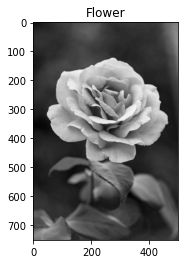

In [14]:
original = cv2.imread('Dataset/flower.jpeg')
Flower= cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
plt.imshow(Flower, cmap='gray')
plt.title('Flower')
plt.savefig('Flower_gray.jpg') 
plt.show()  

### Convolve masks with image 

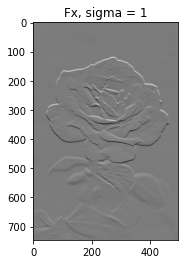

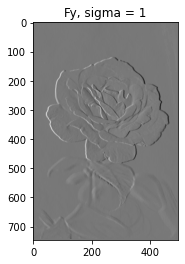

In [20]:
Fx = convolution(Flower,Gx,stride)
Fy = convolution(Flower,Gy,stride)
plt.imshow(Fx, cmap='gray')
plt.title('Fx, sigma = 1')
plt.savefig('Results/Flower_Fx_1')
plt.show()       
plt.imshow(Fy, cmap='gray')
plt.title('Fy, sigma = 1')
plt.savefig('Results/Flower_Fy_1')
plt.show()

### Magnitude computation 

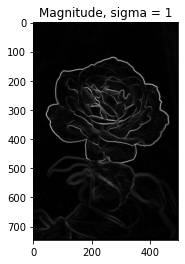

In [21]:
Magnitude= np.hypot(Fx,Fy)
Magnitude = scale_down(Magnitude, scale)
plt.imshow(Magnitude, cmap='gray')
plt.title('Magnitude, sigma = 1')
plt.savefig('Results/Flower_magnitude_1.jpg')
plt.show()

### Quantization 

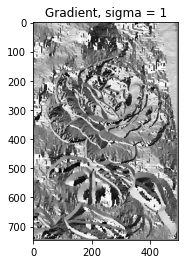

In [22]:
Gradient_d= np.degrees(np.arctan2(Fy,Fx))+180
plt.imshow(Gradient_d, cmap='gray')
plt.title('Gradient, sigma = 1')
plt.savefig('Results/Flower_quantized_1')
plt.show()

### Non Maximum Supression 

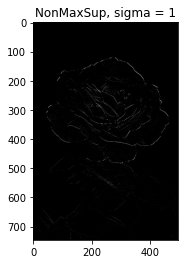

In [23]:
NonMaxSup_image=NonMaxSup(Magnitude, Gradient_d)
plt.imshow(NonMaxSup_image, cmap='gray')
plt.title('NonMaxSup, sigma = 1')
plt.savefig('Results/Flower_NonMaxSup_1')
plt.show()

### Hysteresis thresholding 

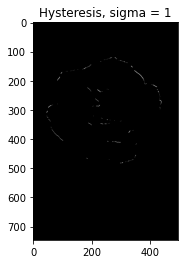

In [24]:
Final_edges = Thresholded_image(NonMaxSup_image)
plt.imshow(Final_edges, cmap='gray')
plt.title('Hysteresis, sigma = 1')
plt.savefig('Results/Flower_finalresult_1')
plt.show()